# BEM 111 HW 3
## Iris Xiang 

### Problem 4

In [13]:
import qrpm_funcs as qf
import numpy as np
import pandas as pd

#getting data 
seriesnames=['DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2', \
             'DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
maturities=qf.TenorsFromNames(seriesnames)
lastday=qf.LastYearEnd()
firstday=qf.LastYearEnd(int(lastday[:4])-1)
dates_dirty,prices_dirty=qf.GetFREDMatrix(seriesnames, \
            startdate=firstday,enddate=lastday)
#remove no-data periods
nan_list=[any(np.isnan(p)) for p in prices_dirty]
prices=[prices_dirty[i] for i in range(len(prices_dirty)) if not nan_list[i]]
dates=[dates_dirty[i] for i in range(len(dates_dirty)) if not nan_list[i]]

In [16]:
prices = pd.DataFrame(prices)
# we compute the day over day arithmetic changes in yields 
change_yields = prices.diff()
# calculating covariance matrix
cov = change_yields.cov(ddof = 1)

# compute eigenvectors 
eigenvalues, eigenvectors = np.linalg.eig(cov)

# computing the percentage of trace contained within first 3 PCs
trace = np.trace(cov)
percentage_of_trace = (eigenvalues[0] + eigenvalues[1] +eigenvalues[2])/trace*100
percentage_of_trace


94.35231626784429

We see that the first 3 PCs contain 94.35% of the trace, or 94.35% of the total variance. 

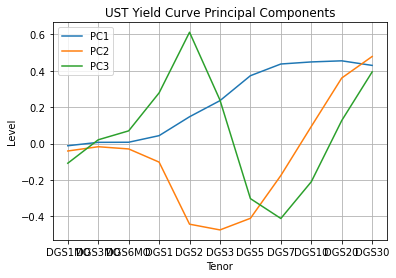

In [21]:
import matplotlib.pyplot as plt
# Graphing first 3 eigenvectors 
pc1 = eigenvectors[:,0]
pc2 = eigenvectors[:,1]
pc3 = eigenvectors[:,2]
date_num = range(len(seriesnames))
plt.plot(date_num, pc1, label = 'PC1')
plt.plot(date_num, pc2, label = 'PC2')
plt.plot(date_num, pc3, label = 'PC3')

plt.title("UST Yield Curve Principal Components")
plt.xlabel('Tenor')
plt.ylabel("Level")
plt.legend()
plt.xticks(date_num, seriesnames)
plt.grid(True)
plt.show()

This looks similar to the Frye eigenvectors, but the individual eigenvectors are sloping differently, such as the sharply peaking PC3, or the deep trough in PC2. These differences are probably because the Frye vectors are taken from 1989 to 1995, while our data is much more recent, so the increased volatility is likely from events such as the 2008 recession. 

### Problem 5

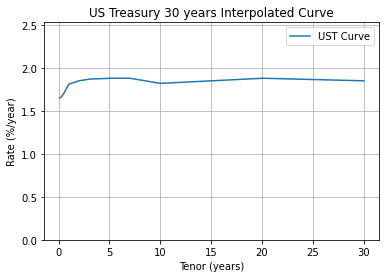

In [53]:
# Create interpolated curve of 30 year maturity
tenors, curvemonthly, shortrates = qf.InterpolateCurve(maturities, prices.iloc[:,-1])

plt.plot(tenors, curvemonthly, label="UST Curve")
## Configure the graph
plt.title('US Treasury 30 years Interpolated Curve')
plt.xlabel('Tenor (years)')
plt.ylabel('Rate (%/year)')
plt.ylim(0,max(shortrates)+.5)
plt.legend()
plt.grid(True)
plt.show;

In [48]:
# fit nelson siegel curve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from nelson_siegel_svensson import NelsonSiegelCurve
t = np.array(tenors)
y = np.array(curvemonthly)
curve, status = calibrate_ns_ols(t, y)
assert status.success
print(curve)

NelsonSiegelCurve(beta0=1.854803871743326, beta1=-0.26600650402997217, beta2=0.3370347092757909, tau=0.8450319810609562)


In [49]:
ns_curve = NelsonSiegelCurve.zero(curve, t)


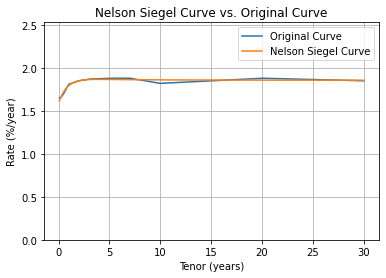

In [51]:
# Plot Nelson Siegel curve against original curve
plt.plot(tenors, curvemonthly, label='Original Curve')
plt.plot(tenors, ns_curve, label='Nelson Siegel Curve')
plt.title('Nelson Siegel Curve vs. Original Curve')
plt.xlabel('Tenor (years)')
plt.ylabel('Rate (%/year)')
plt.ylim(0,max(shortrates)+.5)
plt.legend()
plt.grid(True)
plt.show;

The Nelson-Siegel curve implies that the perpetual interest rate eventually plateaus as the bond matures into 15+ years. 